In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/TL_in_RL

/content/drive/MyDrive/TL_in_RL


In [ ]:
!pip install -U gym box2d-py > /dev/null 2>&1

In [ ]:
import random
from collections import namedtuple, deque
import pdb

import gym
import numpy as np
import matplotlib.pyplot as plt

import torch
torch.manual_seed(0) # set random seed
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

import Box2D
import os
import pickle
path_to_project = 'storage/reinforce_cart_tasks'
plots_path = os.path.join(path_to_project, 'plots')
data_path = os.path.join(path_to_project, 'data')
models_path = os.path.join(path_to_project, 'models')

# Variables

In [ ]:
class Variables:
    SEED=42
    CARTPOLE_BASELINE_CHECKPOINT_NAME=os.path.join('storage/reinforce_cart_tasks/models', 'CartPole_baseline_checkpoint_reinforce.pth')
    LANDER_BASELINE_CHECKPOINT_NAME=os.path.join('storage/reinforce_lander_tasks/models', 'Lander_baseline_checkpoint.pth')
    NUM_SEEDS=5
    NUM_TASKS=5
    NUM_EPISODES=1500
    DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Reinforce

In [ ]:
class Policy_3_Layers(nn.Module):
    def __init__(self, s_size=4, a_size=2, fc1_units=64, fc2_units=64, device=Variables.DEVICE,
                 seed=Variables.SEED, transform=None):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
            transform (callable): If NoneType: Some transform applied on the state
        """
        super(Policy_3_Layers, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.transform = transform
        self.fc1 = nn.Linear(s_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, a_size)
        self.to(device)
        self.device = device

    def forward(self, state):
        """Build a network that maps state -> action values."""
        if self.transform:
            state = self.transform(state)
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        out = F.softmax(x, dim=1)
        return out

    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0).to(self.device)
        probs = self.forward(state).cpu()
        m = Categorical(probs)
        action = m.sample()
        return action.item(), m.log_prob(action)


def reinforce(env, policy, optimizer, n_episodes=1000, max_t=1000, gamma=1.0, print_every=100,
              checkpoint_name='checkpoint.pth', score_threshold=195.0, do_print=False):
    scores_deque = deque(maxlen=100)
    scores = []
    for i_episode in range(1, n_episodes+1):
        saved_log_probs = []
        rewards = []
        state = env.reset()
        for t in range(max_t):
            action, log_prob = policy.act(state)
            saved_log_probs.append(log_prob)
            state, reward, done, _ = env.step(action)
            rewards.append(reward)
            if done:
                break 
        scores_deque.append(sum(rewards))
        scores.append(sum(rewards))
        
        discounts = [gamma**i for i in range(len(rewards)+1)]
        R = sum([a*b for a,b in zip(discounts, rewards)])
        
        policy_loss = []
        for log_prob in saved_log_probs:
            policy_loss.append(-log_prob * R)
        policy_loss = torch.cat(policy_loss).sum()
        
        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()
        
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)), end="")
        # if i_episode % print_every == 0:
        #     if do_print: print('Episode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
        if np.mean(scores_deque)>=score_threshold:
            # print('Environment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_deque)))
            break
    torch.save(policy.state_dict(), checkpoint_name)
    return scores


def sample_cartpole_tasks(num_tasks, random_state, variable=None):
    if variable is not None:
        if variable == 'gravity':
            gravity = random_state.normal(loc=9.8, size=(num_tasks))
            tasks = [{'gravity': g} for g in gravity]

        elif variable == 'masscart':
            masscart = random_state.normal(loc=1.0, scale=0.25, size=(num_tasks))
            total_mass = np.array([m1 + 0.1 for m1 in masscart])
            tasks = [{'masscart': mc, 'total_mass': mt} for mc, mt in zip(masscart, total_mass)]

        elif variable == 'masspole':
            masspole = random_state.normal(loc=0.1, scale=0.025, size=(num_tasks))
            total_mass = np.array([m1 + 1.0 for m1 in masspole])
            tasks = [{'masspole': mp, 'total_mass': mt} for mp, mt, in zip(masspole, total_mass)]

        elif variable == 'length':
            length = random_state.normal(loc=0.5, scale=0.125, size=num_tasks)
            tasks = [{'length': l} for l in length]

        elif variable == 'polemass_length':
            polemass_length = random_state.normal(loc=0.05, scale=0.0125, size=num_tasks)
            tasks = [{'polemass_length': l} for l in polemass_length]
            
        elif variable == 'force_mag':
            force_mag = random_state.normal(loc=10, size=num_tasks)
            tasks = [{'force_mag': fg} for fg in force_mag]

        else:
            raise NotImplementedError(f"No such variable {variable}")
    else:
        # gravity = random_state.normal(loc=9.8, size=(num_tasks))
        masscart = random_state.normal(loc=1.0, scale=0.25, size=(num_tasks))
        masspole = random_state.normal(loc=0.1, scale=0.025, size=(num_tasks))
        total_mass = np.array([m1 + m2 for m1, m2 in zip(masscart, masspole)])
        length = random_state.normal(loc=0.5, scale=0.125, size=num_tasks)
        polemass_length = random_state.normal(loc=0.05, scale=0.0125, size=num_tasks)
        # force_mag = random_state.normal(loc=10, size=num_tasks)
        # tasks = [{'gravity': g, 'masscart': mc, 'masspole': mp, 'total_mass': mt, 'length': l,
        #             'polemass_length': pl, 'force_mag': fg} for g, mc, mp, mt, l, pl, fg in zip(gravity, 
        #             masscart, masspole, total_mass, length, polemass_length, force_mag)]
        tasks = [{'masscart': mc, 'masspole': mp, 'total_mass': mt, 'length': l,
                    'polemass_length': pl} for mc, mp, mt, l, pl in zip(masscart, 
                    masspole, total_mass, length, polemass_length)]
    return tasks


def set_task(env, task):
    for k, v in task.items():
        env.env.__dict__[k] = v
    return env

# CartPole-v1

## Baseline

In [ ]:
env = gym.make('CartPole-v1')
env.seed(Variables.SEED)

# env = ch.envs.Logger(env, episode_interval=500)
# env = ch.envs.Recorder(env)

s_size = env.observation_space.shape[0]
a_size = env.action_space.n

print(f'Observation space: {s_size}')
print(f'Action space: {a_size}')

torch.cuda.empty_cache()
policy = Policy_3_Layers(s_size=s_size, a_size=a_size, fc1_units=64, fc2_units=64)
optimizer = optim.Adam(policy.parameters(), lr=5e-4)

Observation space: 4
Action space: 2


In [ ]:
scores_baseline = reinforce(env, policy, optimizer, n_episodes=Variables.NUM_EPISODES, max_t=200,
                            checkpoint_name=Variables.CARTPOLE_BASELINE_CHECKPOINT_NAME, do_print=True,
                            score_threshold=400)

Episode 1500	Average Score: 190.15

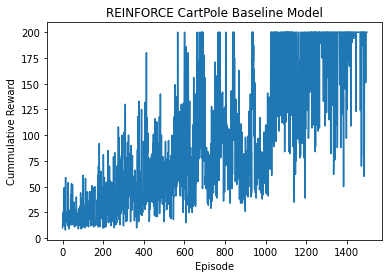

In [ ]:
plt.plot(scores_baseline)
plt.xlabel('Episode')
plt.ylabel('Cummulative Reward')
plt.title('REINFORCE CartPole Baseline Model')
plt.savefig(os.path.join(plots_path, 'baseline.png'))
plt.show()

## New Tasks

In [ ]:
Variables.NUM_TASKS = 5
Variables.NUM_EPISODES = 1500
Variables.NUM_SEEDS = 5

random_state = np.random.RandomState(Variables.SEED)
tasks = sample_cartpole_tasks(Variables.NUM_TASKS, random_state)

history_transfer = []
history_scratch = []

average_transfer_per_task = []
variance_transfer_per_task = []

average_scratch_per_task = []
variance_scratch_per_task = []

for i, task in enumerate(tasks):
    scores_transfer_per_seed = []
    scores_scratch_per_seed = []
    env = gym.make('CartPole-v1')
    set_task(env, task)

    for seed in range(Variables.NUM_SEEDS):
        env.seed(seed)
        # env.reset()

        s_size = env.observation_space.shape[0]
        a_size = env.action_space.n

        # Transfer agent needs to load the weights for each new task
        agent_transfer = Policy_3_Layers(s_size=s_size, a_size=a_size)
        agent_transfer.load_state_dict(torch.load(Variables.CARTPOLE_BASELINE_CHECKPOINT_NAME))

        # Agent from scratch has its weights initialized randomly for each new task
        agent_scratch = Policy_3_Layers(s_size=s_size, a_size=a_size)

        # Train both
        optimizer = optim.Adam(agent_scratch.parameters(), lr=5e-4)
        scores_scratch = reinforce(env, agent_scratch, optimizer, n_episodes=Variables.NUM_EPISODES, max_t=200, 
                             score_threshold=400, checkpoint_name=f'CartPole_scratch_task_{i}')
        
        optimizer = optim.Adam(agent_transfer.parameters(), lr=5e-4)
        scores_transfer = reinforce(env, agent_transfer, optimizer, n_episodes=Variables.NUM_EPISODES, max_t=200,
                              score_threshold=400, checkpoint_name=f'CartPole_transfer_task_{i}')
        
        scores_transfer_per_seed.append(scores_transfer)
        scores_scratch_per_seed.append(scores_scratch)

    history_transfer.append(scores_transfer_per_seed)
    history_scratch.append(scores_scratch_per_seed)

Episode 1500	Average Score: 191.80

In [ ]:
for task_idx, task_ls in enumerate(history_transfer):
    for seed_idx, seed_ls in enumerate(task_ls):
        if len(seed_ls) < Variables.NUM_EPISODES:
            diff = Variables.NUM_EPISODES - len(seed_ls)
            last_reward = seed_ls[-1]
            for i in range(diff):
                seed_ls.append(last_reward)

for task_idx, task_ls in enumerate(history_scratch):
    for seed_idx, seed_ls in enumerate(task_ls):
        if len(seed_ls) < Variables.NUM_EPISODES:
            diff = Variables.NUM_EPISODES - len(seed_ls)
            last_reward = seed_ls[-1]
            for i in range(diff):
                seed_ls.append(last_reward)

In [ ]:
average_transfer_per_task = []
variance_transfer_per_task = []

average_scratch_per_task = []
variance_scratch_per_task = []

for ls_transfer, ls_scratch in zip(history_transfer, history_scratch):

    average_transfer_per_task.append(np.average(ls_transfer, axis=0))
    variance_transfer_per_task.append(np.var(ls_transfer, axis=0))

    average_scratch_per_task.append(np.average(ls_scratch, axis=0))
    variance_scratch_per_task.append(np.var(ls_scratch, axis=0))

In [ ]:
path_to_project = 'storage/reinforce_cart_tasks'
plots_path = os.path.join(path_to_project, 'plots')
data_path = os.path.join(path_to_project, 'data')

In [ ]:
save = True
if save:
    with open(os.path.join(data_path, 'history_transfer.list'), 'wb') as f:
        pickle.dump(history_transfer, f)
    with open(os.path.join(data_path,'history_scratch.list'), 'wb') as f:
        pickle.dump(history_scratch, f)
    with open(os.path.join(data_path,'average_transfer_per_task.list'), 'wb') as f:
        pickle.dump(average_transfer_per_task, f)
    with open(os.path.join(data_path,'variance_transfer_per_task.list'), 'wb') as f:
        pickle.dump(variance_transfer_per_task, f)
    with open(os.path.join(data_path,'average_scratch_per_task.list'), 'wb') as f:
        pickle.dump(average_scratch_per_task, f)
    with open(os.path.join(data_path,'variance_scratch_per_task.list'), 'wb') as f:
        pickle.dump(variance_scratch_per_task, f)
    with open(os.path.join(data_path, 'tasks.list'), 'wb') as f:
        pickle.dump(tasks, f)

In [ ]:
load = False
if load:
    # with open(os.path.join(data_path, 'history_transfer.list'), 'rb') as f:
    #     history_transfer = pickle.load(f)

    # with open(os.path.join(data_path,'history_scratch.list'), 'rb') as f:
    #     history_scratch = pickle.load(f)

    with open(os.path.join(data_path,'average_transfer_per_task.list'), 'rb') as f:
        average_transfer_per_task = pickle.load(f)

    with open(os.path.join(data_path,'variance_transfer_per_task.list'), 'rb') as f:
        variance_transfer_per_task = pickle.load(f)

    with open(os.path.join(data_path,'average_scratch_per_task.list'), 'rb') as f:
        average_scratch_per_task = pickle.load(f)

    with open(os.path.join(data_path,'variance_scratch_per_task.list'), 'rb') as f:
        variance_scratch_per_task = pickle.load(f)

    with open(os.path.join(data_path, 'tasks.list'), 'rb') as f:
        tasks = pickle.load(f)

{'masscart': 1.1241785382528082, 'masspole': 0.09414657607627049, 'total_mass': 1.2183251143290788, 'length': 0.4420727883984422, 'polemass_length': 0.04297140588448784}


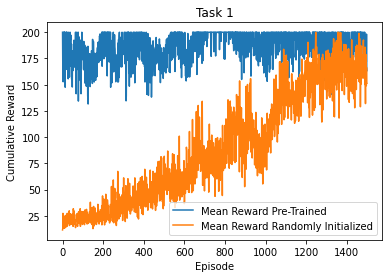

{'masscart': 0.9654339247072038, 'masspole': 0.1394803203876848, 'total_mass': 1.1049142450948886, 'length': 0.4417837808037179, 'polemass_length': 0.03733961099581971}


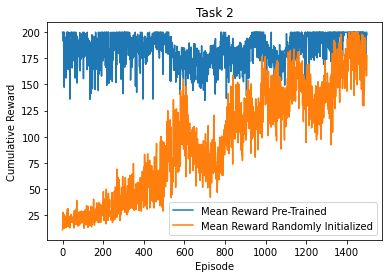

{'masscart': 1.1619221345251731, 'masspole': 0.11918586822882273, 'total_mass': 1.2811080027539958, 'length': 0.5302452839457543, 'polemass_length': 0.053928091657440926}


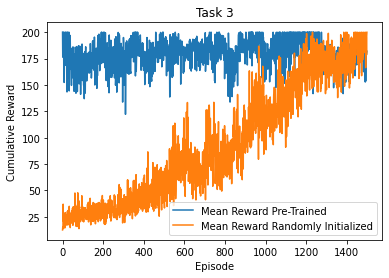

{'masscart': 1.3807574641020064, 'masspole': 0.0882631403516262, 'total_mass': 1.4690206044536327, 'length': 0.26083996941777526, 'polemass_length': 0.038649699055984865}


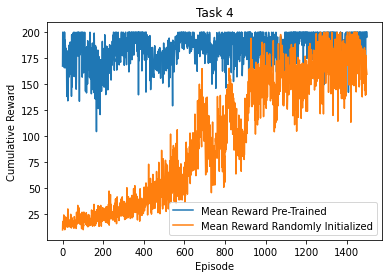

{'masscart': 0.941461656319166, 'masspole': 0.11356400108964912, 'total_mass': 1.055025657408815, 'length': 0.2843852709358709, 'polemass_length': 0.03234620373330886}


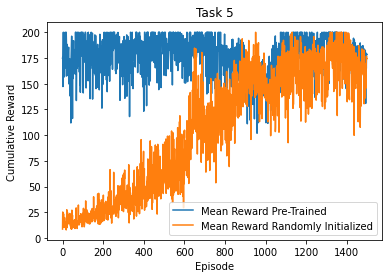

In [ ]:
x_ticks = [i for i in range(Variables.NUM_EPISODES)]
for i in range(Variables.NUM_TASKS):
    average = average_transfer_per_task[i] 
    variance = variance_transfer_per_task[i]

    # plt.figure(figsize=(12,6))
    plt.plot(average)
    # plt.fill_between(x_ticks, average+variance, average-variance, alpha=0.4)

    average = average_scratch_per_task[i] 
    variance = variance_scratch_per_task[i]
    plt.plot(average)
    # plt.fill_between(x_ticks, average+variance, average-variance, alpha=0.4)

    print(tasks[i])
    
    plt.title(f'Task {i+1}')
    plt.xlabel('Episode')
    plt.ylabel('Cumulative Reward')
    plt.legend((('Mean Reward Pre-Trained', 'Mean Reward Randomly Initialized')))
    plt.savefig(os.path.join(plots_path, f'task_{i+1}_cart_reinforce.png'))
    plt.show()

{'masscart': 1.1241785382528082, 'masspole': 0.09414657607627049, 'total_mass': 1.2183251143290788, 'length': 0.4420727883984422, 'polemass_length': 0.04297140588448784}


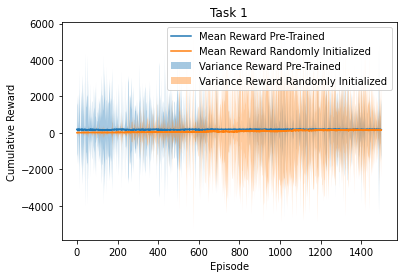

{'masscart': 0.9654339247072038, 'masspole': 0.1394803203876848, 'total_mass': 1.1049142450948886, 'length': 0.4417837808037179, 'polemass_length': 0.03733961099581971}


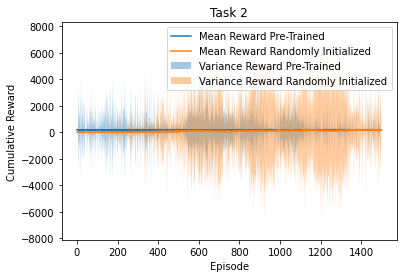

{'masscart': 1.1619221345251731, 'masspole': 0.11918586822882273, 'total_mass': 1.2811080027539958, 'length': 0.5302452839457543, 'polemass_length': 0.053928091657440926}


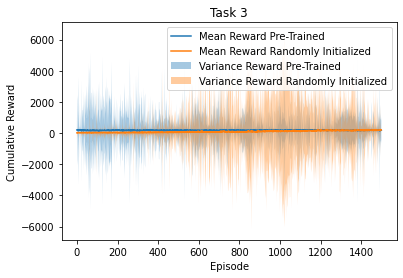

{'masscart': 1.3807574641020064, 'masspole': 0.0882631403516262, 'total_mass': 1.4690206044536327, 'length': 0.26083996941777526, 'polemass_length': 0.038649699055984865}


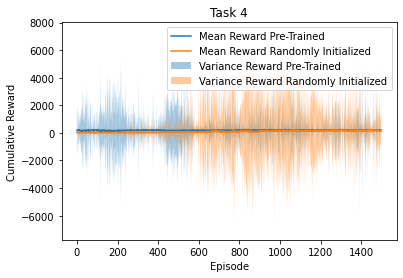

{'masscart': 0.941461656319166, 'masspole': 0.11356400108964912, 'total_mass': 1.055025657408815, 'length': 0.2843852709358709, 'polemass_length': 0.03234620373330886}


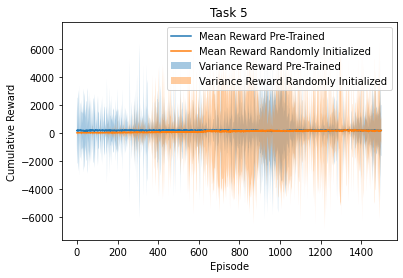

In [ ]:
x_ticks = [i for i in range(Variables.NUM_EPISODES)]
for i in range(Variables.NUM_TASKS):
    average = average_transfer_per_task[i] 
    variance = variance_transfer_per_task[i]

    # plt.figure(figsize=(12,6))
    plt.plot(average)
    plt.fill_between(x_ticks, average+variance, average-variance, alpha=0.4)

    average = average_scratch_per_task[i] 
    variance = variance_scratch_per_task[i]
    plt.plot(average)
    plt.fill_between(x_ticks, average+variance, average-variance, alpha=0.4)

    print(tasks[i])
    plt.title(f'Task {i+1}')
    plt.xlabel('Episode')
    plt.ylabel('Cumulative Reward')
    plt.legend(('Mean Reward Pre-Trained', 'Mean Reward Randomly Initialized',
                 'Variance Reward Pre-Trained', 'Variance Reward Randomly Initialized'))
    plt.savefig(os.path.join(plots_path, f'w_variance_task_{i+1}_cart_reinforce.png'))
    # plt.savefig(os.path.join(plots_path, f'big_w_variance_task_{i+1}_cart_reinforce.png'))
    plt.show()

# Lunar Lander

In [ ]:
path_to_project = 'storage/reinforce_lander_tasks'
plots_path = os.path.join(path_to_project, 'plots')
data_path = os.path.join(path_to_project, 'data')
models_path = os.path.join(path_to_project, 'models')
Variables.LANDER_BASELINE_CHECKPOINT_NAME = os.path.join(models_path, 'Lander_baseline.pth')

## Baseline

In [ ]:
import pdb
class Policy_3_Layers(nn.Module):
    def __init__(self, s_size=4, a_size=2, fc1_units=64, fc2_units=64, device=Variables.DEVICE,
                 seed=Variables.SEED, transform=None):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
            transform (callable): If NoneType: Some transform applied on the state
        """
        super(Policy_3_Layers, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.transform = transform
        self.fc1 = nn.Linear(s_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, a_size)
        self.to(device)
        self.device = device

    def forward(self, state):
        """Build a network that maps state -> action values."""
        if self.transform:
            state = self.transform(state)
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = F.softmax(x, dim=1)
        return x

    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0).to(self.device)
        probs = self.forward(state).cpu()
        m = Categorical(probs)
        action = m.sample()
        return action.item(), m.log_prob(action)
    

def reinforce(env, policy, optimizer, n_episodes=1000, max_t=1000, gamma=1.0, print_every=100,
              checkpoint_name='checkpoint.pth', score_threshold=195.0, do_print=False):
    scores_deque = deque(maxlen=100)
    scores = []
    for i_episode in range(1, n_episodes+1):
        saved_log_probs = []
        rewards = []
        state = env.reset()
        for t in range(max_t):
            action, log_prob = policy.act(state)
            saved_log_probs.append(log_prob)
            state, reward, done, _ = env.step(action)
            rewards.append(reward)
            if done:
                break 
        scores_deque.append(sum(rewards))
        scores.append(sum(rewards))
        
        discounts = np.array([gamma**i for i in range(len(rewards))])
#         discounted_rewards = discounts * np.array(rewards)
        discounted_rewards = [a*b for a,b in zip(discounts, rewards)]
        discounted_rewards -= np.mean(discounted_rewards)
        discounted_rewards /= np.std(discounted_rewards)
#         R = sum([a*b for a,b in zip(discounts, rewards)])
#         pdb.set_trace()
#         R -= np.mean(R)
#         R /= np.std(R)
        
        policy_loss = []
        for log_prob, dr in zip(saved_log_probs, discounted_rewards):
            policy_loss.append(-log_prob * dr)
        policy_loss = torch.cat(policy_loss).mean()
        
        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()
        
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)), end="")
        # if i_episode % print_every == 0:
        #     if do_print: print('Episode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
        if np.mean(scores_deque)>=score_threshold:
            # print('Environment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_deque)))
            break
    torch.save(policy.state_dict(), checkpoint_name)
    return scores

In [ ]:
env2 = gym.make('LunarLander-v2')
env2.seed(0)

s_size = env2.observation_space.shape[0]
a_size = env2.action_space.n

print(f'Observation space: {s_size}')
print(f'Action space: {a_size}')

baseline_2 = Policy_3_Layers(s_size=s_size, a_size=a_size, seed=0, fc1_units=16, fc2_units=32)
optimizer = optim.Adam(baseline_2.parameters(), lr=5e-3)

Observation space: 8
Action space: 4


In [ ]:
baseline_2_scores = reinforce(env2, baseline_2, optimizer, n_episodes=1500, gamma=0.99, max_t=1000,
                              checkpoint_name=Variables.LANDER_BASELINE_CHECKPOINT_NAME,
                              do_print=True)

Episode 1500	Average Score: -16.32

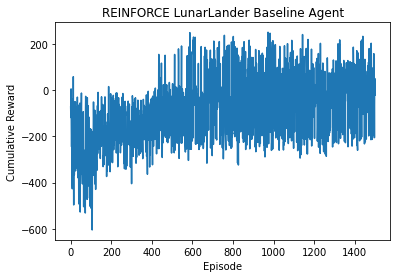

In [ ]:
plt.plot(baseline_2_scores)
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.title('REINFORCE LunarLander Baseline Agent')
plt.savefig(os.path.join(plots_path, 'baseline.png'))
plt.show()

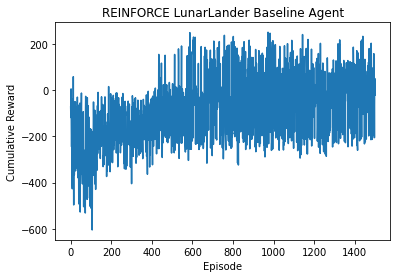

In [ ]:
plt.plot(baseline_2_scores)
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.title('REINFORCE LunarLander Baseline Agent')
# plt.savefig(os.path.join(plots_path, 'baseline.png'))
plt.show()

## New Tasks

In [ ]:
def sample_lander_tasks(num_tasks, random_state):
    mass = random_state.normal(loc=4.816666603088379, scale=1, size=num_tasks)
    gravity = random_state.normal(loc=-10, scale=1, size=num_tasks)
    tasks = [{'mass': m, 'gravity': Box2D.b2Vec2(0, g)} for m, g in zip(mass, gravity)]
    return tasks


def set_lander_task(env, task):
    for k, v in task.items():
#         if k == 'mass':
#             env.env.__dict__['lander'].mass = v
        if k == 'gravity':
            env.env.__dict__['world'].gravity = v
    return env

In [ ]:
Variables.NUM_TASKS = 5
Variables.NUM_EPISODES = 1500
Variables.NUM_SEEDS = 5

random_state = np.random.RandomState(Variables.SEED)
tasks = sample_lander_tasks(Variables.NUM_TASKS, random_state)

history_transfer = []
history_scratch = []

for i, task in enumerate(tasks):

    scores_transfer_per_seed = []
    scores_scratch_per_seed = []
    env = gym.make('LunarLander-v2')
    set_lander_task(env, task)

    for seed in range(Variables.NUM_SEEDS):
        env.seed(seed)

        s_size = env.observation_space.shape[0]
        a_size = env.action_space.n

        # Transfer agent needs to load the weights for each new task
        agent_transfer = Policy_3_Layers(s_size=s_size, a_size=a_size, seed=seed, fc1_units=16, fc2_units=32)
        agent_transfer.load_state_dict(torch.load(Variables.LANDER_BASELINE_CHECKPOINT_NAME))

        # Agent from scratch has its weights initialized randomly for each new task
        agent_scratch = Policy_3_Layers(s_size=s_size, a_size=a_size, seed=seed, fc1_units=16, fc2_units=32)

        # Train both
        optimizer = optim.Adam(agent_scratch.parameters(), lr=5e-3)
        scores_scratch = reinforce(env, agent_scratch, optimizer, n_episodes=Variables.NUM_EPISODES, 
                             score_threshold=200, checkpoint_name=os.path.join(models_path, f'Lander_scratch_task_{i}'))
        
        optimizer = optim.Adam(agent_transfer.parameters(), lr=5e-3)
        scores_transfer = reinforce(env, agent_transfer, optimizer, n_episodes=Variables.NUM_EPISODES,
                              score_threshold=200, checkpoint_name=os.path.join(models_path, f'Lander_transfer_task_{i}'))
        
        scores_transfer_per_seed.append(scores_transfer)
        scores_scratch_per_seed.append(scores_scratch)

    history_transfer.append(scores_transfer_per_seed)
    history_scratch.append(scores_scratch_per_seed)

Episode 1500	Average Score: 5.56

In [ ]:
for task_idx, task_ls in enumerate(history_transfer):
    for seed_idx, seed_ls in enumerate(task_ls):
        if len(seed_ls) < Variables.NUM_EPISODES:
            diff = Variables.NUM_EPISODES - len(seed_ls)
            last_reward = seed_ls[-1]
            for i in range(diff):
                seed_ls.append(last_reward)

for task_idx, task_ls in enumerate(history_scratch):
    for seed_idx, seed_ls in enumerate(task_ls):
        if len(seed_ls) < Variables.NUM_EPISODES:
            diff = Variables.NUM_EPISODES - len(seed_ls)
            last_reward = seed_ls[-1]
            for i in range(diff):
                seed_ls.append(last_reward)
                
average_transfer_per_task = []
variance_transfer_per_task = []

average_scratch_per_task = []
variance_scratch_per_task = []

for ls_transfer, ls_scratch in zip(history_transfer, history_scratch):

    average_transfer_per_task.append(np.average(ls_transfer, axis=0))
    variance_transfer_per_task.append(np.var(ls_transfer, axis=0))

    average_scratch_per_task.append(np.average(ls_scratch, axis=0))
    variance_scratch_per_task.append(np.var(ls_scratch, axis=0))

In [ ]:
tasks_gravity_only = [d['gravity'].y for d in tasks]

In [ ]:
save = True
if save:
    with open(os.path.join(data_path, 'history_transfer.list'), 'wb') as f:
        pickle.dump(history_transfer, f)
    with open(os.path.join(data_path,'history_scratch.list'), 'wb') as f:
        pickle.dump(history_scratch, f)
    with open(os.path.join(data_path,'average_transfer_per_task.list'), 'wb') as f:
        pickle.dump(average_transfer_per_task, f)
    with open(os.path.join(data_path,'variance_transfer_per_task.list'), 'wb') as f:
        pickle.dump(variance_transfer_per_task, f)
    with open(os.path.join(data_path,'average_scratch_per_task.list'), 'wb') as f:
        pickle.dump(average_scratch_per_task, f)
    with open(os.path.join(data_path,'variance_scratch_per_task.list'), 'wb') as f:
        pickle.dump(variance_scratch_per_task, f)
    with open(os.path.join(data_path, 'tasks_gravity_only.list'), 'wb') as f:
        pickle.dump(tasks_gravity_only, f)

load = False
if load:
    with open(os.path.join(data_path, 'history_transfer.list'), 'rb') as f:
        history_transfer = pickle.load(f)

    with open(os.path.join(data_path,'history_scratch.list'), 'rb') as f:
        history_scratch = pickle.load(f)

    with open(os.path.join(data_path,'average_transfer_per_task.list'), 'rb') as f:
        average_transfer_per_task = pickle.load(f)

    with open(os.path.join(data_path,'variance_transfer_per_task.list'), 'rb') as f:
        variance_transfer_per_task = pickle.load(f)

    with open(os.path.join(data_path,'average_scratch_per_task.list'), 'rb') as f:
        average_scratch_per_task = pickle.load(f)

    with open(os.path.join(data_path,'variance_scratch_per_task.list'), 'rb') as f:
        variance_scratch_per_task = pickle.load(f)

    with open(os.path.join(data_path, 'tasks_gravity_only.list'), 'wb') as f:
        pickle.dump(tasks_gravity_only, f)

{'mass': 5.313380756099612, 'gravity': b2Vec2(0,-10.2341)}


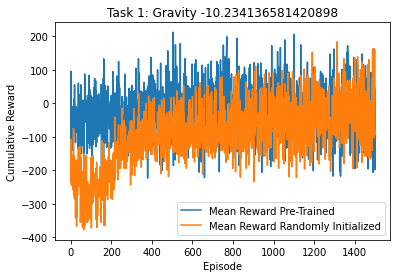

{'mass': 4.6784023019171945, 'gravity': b2Vec2(0,-8.42079)}


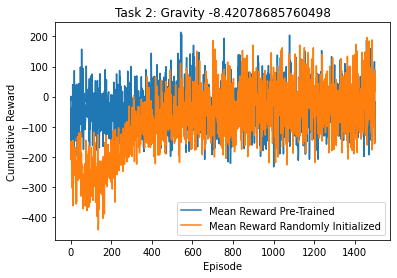

{'mass': 5.464355141189071, 'gravity': b2Vec2(0,-9.23256)}


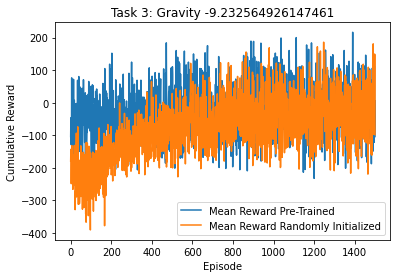

{'mass': 6.3396964594964045, 'gravity': b2Vec2(0,-10.4695)}


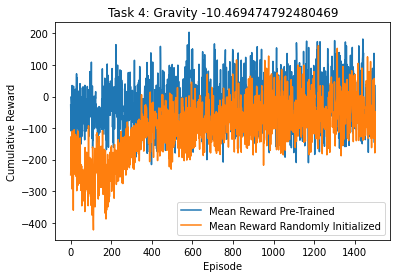

{'mass': 4.582513228365043, 'gravity': b2Vec2(0,-9.45744)}


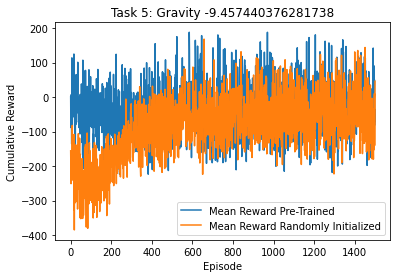

In [ ]:
x_ticks = [i for i in range(Variables.NUM_EPISODES)]
for i in range(Variables.NUM_TASKS):
    print(tasks[i])
    
    average = average_transfer_per_task[i] 
    plt.plot(average)

    average = average_scratch_per_task[i] 
    plt.plot(average)
    
    plt.title(f"Task {i+1}: Gravity {tasks_gravity_only[i]}")
    plt.xlabel('Episode')
    plt.ylabel('Cumulative Reward')
    plt.legend(('Mean Reward Pre-Trained', 'Mean Reward Randomly Initialized'))
    plt.savefig(os.path.join(plots_path, f"task_{i+1}.png"))
    plt.show()

{'mass': 5.313380756099612, 'gravity': b2Vec2(0,-10.2341)}


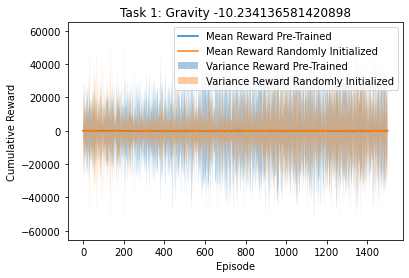

{'mass': 4.6784023019171945, 'gravity': b2Vec2(0,-8.42079)}


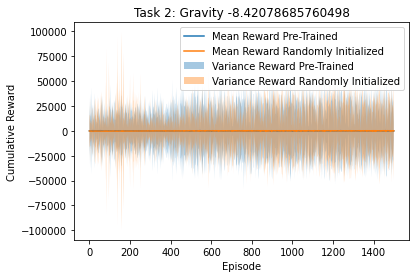

{'mass': 5.464355141189071, 'gravity': b2Vec2(0,-9.23256)}


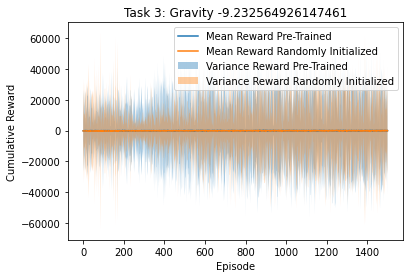

{'mass': 6.3396964594964045, 'gravity': b2Vec2(0,-10.4695)}


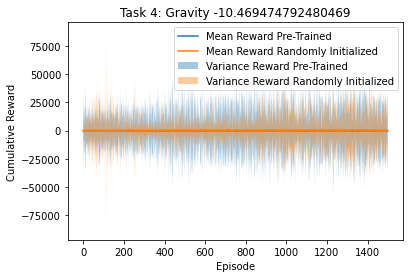

{'mass': 4.582513228365043, 'gravity': b2Vec2(0,-9.45744)}


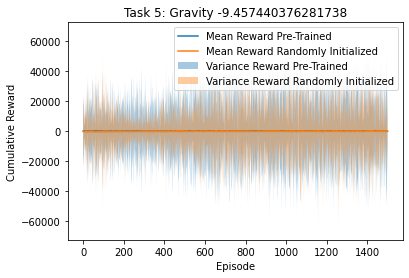

In [ ]:
x_ticks = [i for i in range(Variables.NUM_EPISODES)]
for i in range(Variables.NUM_TASKS):
    print(tasks[i])
    
    average = average_transfer_per_task[i] 
    variance = variance_transfer_per_task[i]
    plt.plot(average)
    plt.fill_between(x_ticks, average+variance, average-variance, alpha=0.4)

    average = average_scratch_per_task[i] 
    variance = variance_scratch_per_task[i]
    plt.plot(average)
    plt.fill_between(x_ticks, average+variance, average-variance, alpha=0.4)

    plt.title(f"Task {i+1}: Gravity {tasks_gravity_only[i]}")
    plt.xlabel('Episode')
    plt.ylabel('Cumulative Reward')
    plt.legend(('Mean Reward Pre-Trained', 'Mean Reward Randomly Initialized',
                 'Variance Reward Pre-Trained', 'Variance Reward Randomly Initialized'))
    plt.savefig(os.path.join(plots_path, f"w_variance_task_{i+1}.png"))
    plt.show()

{'mass': 5.313380756099612, 'gravity': b2Vec2(0,-10.2341)}


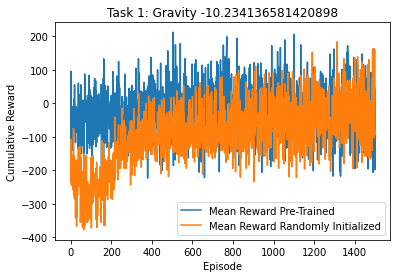

{'mass': 4.6784023019171945, 'gravity': b2Vec2(0,-8.42079)}


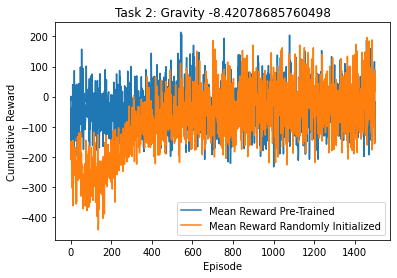

{'mass': 5.464355141189071, 'gravity': b2Vec2(0,-9.23256)}


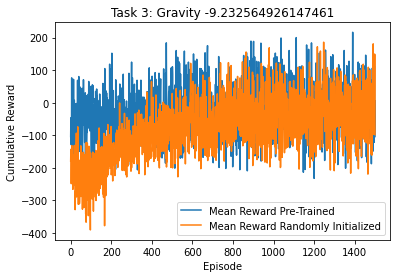

{'mass': 6.3396964594964045, 'gravity': b2Vec2(0,-10.4695)}


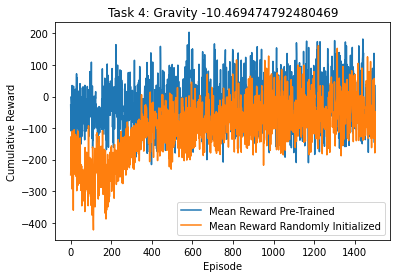

{'mass': 4.582513228365043, 'gravity': b2Vec2(0,-9.45744)}


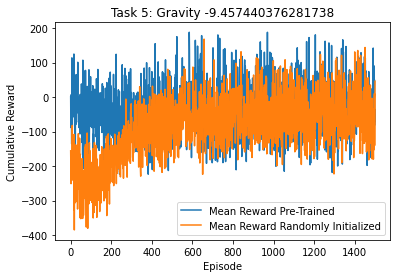

In [ ]:
x_ticks = [i for i in range(Variables.NUM_EPISODES)]
for i in range(Variables.NUM_TASKS):
    print(tasks[i])
    
    average = average_transfer_per_task[i] 
    plt.plot(average)

    average = average_scratch_per_task[i] 
    plt.plot(average)
    
    plt.title(f"Task {i+1}: Gravity {tasks_gravity_only[i]}")
    plt.xlabel('Episode')
    plt.ylabel('Cumulative Reward')
    plt.legend(('Mean Reward Pre-Trained', 'Mean Reward Randomly Initialized'))
    plt.savefig(os.path.join(plots_path, f"task_{i+1}.png"))
    plt.show()

{'mass': 5.313380756099612, 'gravity': b2Vec2(0,-10.2341)}


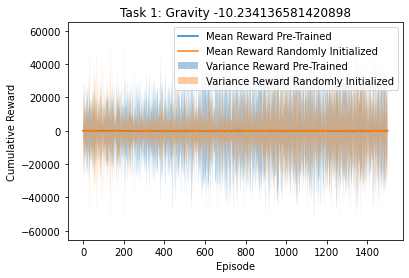

{'mass': 4.6784023019171945, 'gravity': b2Vec2(0,-8.42079)}


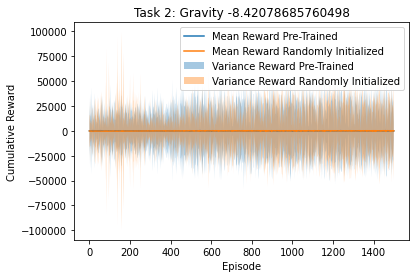

{'mass': 5.464355141189071, 'gravity': b2Vec2(0,-9.23256)}


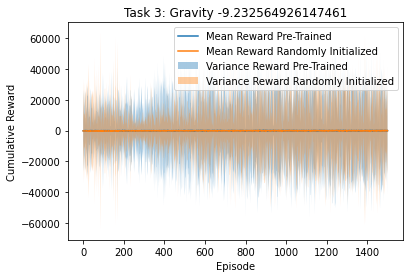

{'mass': 6.3396964594964045, 'gravity': b2Vec2(0,-10.4695)}


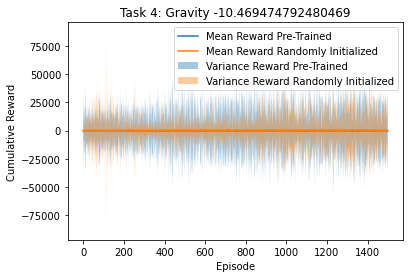

{'mass': 4.582513228365043, 'gravity': b2Vec2(0,-9.45744)}


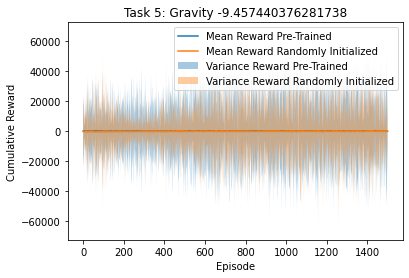

In [ ]:
x_ticks = [i for i in range(Variables.NUM_EPISODES)]
for i in range(Variables.NUM_TASKS):
    print(tasks[i])
    
    average = average_transfer_per_task[i] 
    variance = variance_transfer_per_task[i]
    plt.plot(average)
    plt.fill_between(x_ticks, average+variance, average-variance, alpha=0.4)

    average = average_scratch_per_task[i] 
    variance = variance_scratch_per_task[i]
    plt.plot(average)
    plt.fill_between(x_ticks, average+variance, average-variance, alpha=0.4)

    plt.title(f"Task {i+1}: Gravity {tasks_gravity_only[i]}")
    plt.xlabel('Episode')
    plt.ylabel('Cumulative Reward')
    plt.legend(('Mean Reward Pre-Trained', 'Mean Reward Randomly Initialized',
                 'Variance Reward Pre-Trained', 'Variance Reward Randomly Initialized'))
    plt.savefig(os.path.join(plots_path, f"w_variance_task_{i+1}.png"))
    plt.show()

In [ ]:
env2 = gym.make('LunarLander-v2')
env2.seed(0)

s_size = env2.observation_space.shape[0]
a_size = env2.action_space.n

print(f'Observation space: {s_size}')
print(f'Action space: {a_size}')

agent2 = Agent(state_size=s_size, action_size=a_size, seed=0)

Observation space: 8
Action space: 4


NameError: ignored

In [ ]:
scores2 = dqn(env2, agent2, is_continuous_action=False, n_episodes=1000, mean_score_threshold=300)
plt.plot(scores2)

In [ ]:
plt.plot(scores2_w_transfer)
plt.plot(scores2)
plt.legend(('With Transfer Learning', 'Without Transfer Learning'))
plt.show()